<a href="https://colab.research.google.com/github/zevan07/DS-Unit-2-Tree-Ensembles/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [1]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.5MB/s 


In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'])
assert df.shape == (13958, 20)

In [70]:
# check for null values
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
game_date                  0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [71]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [0]:
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
df['game_month'] = df['game_date'].dt.month
df['game_day'] = df['game_date'].dt.day
df['game_year'] = df['game_date'].dt.year

# add home advantage
df['home_adv'] = df['htm'] == 'GSW'

# more feature engineering
df['opponent'] = (df['vtm'].replace('GSW', '') + df['htm'].replace('GSW', ''))

df['sec_remain_period'] = (df['minutes_remaining'] * 60) + df['seconds_remaining']

df['sec_remain_game'] = (df['minutes_remaining'] * 60) + df['seconds_remaining'] + ((4-df['period']) * 12 * 60)


In [0]:
#train, test, val split
train = df[(df['game_date'] >= '2009-10-1') & (df['game_date'] <= '2017-6-30')]
test = df[(df['game_date'] >= '2017-10-1') & (df['game_date'] <= '2018-6-30')]
val = df[(df['game_date'] >= '2018-10-1') & (df['game_date'] <= '2019-6-30')]

In [148]:
train.shape, test.shape, val.shape

((11081, 28), (1168, 28), (1709, 28))

In [0]:
target = 'shot_made_flag'

In [150]:
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.527209
1    0.472791
Name: shot_made_flag, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [152]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5272087356736757

In [0]:
features = df.columns.tolist()

In [0]:
features.remove('player_name')
features.remove('game_date')
features.remove('shot_made_flag')

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

In [156]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(ce.OrdinalEncoder()
                        , RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6266822703335284


## Part 2

In [157]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6266822703335284


In [158]:
y_test = test[target]
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.5967465753424658


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

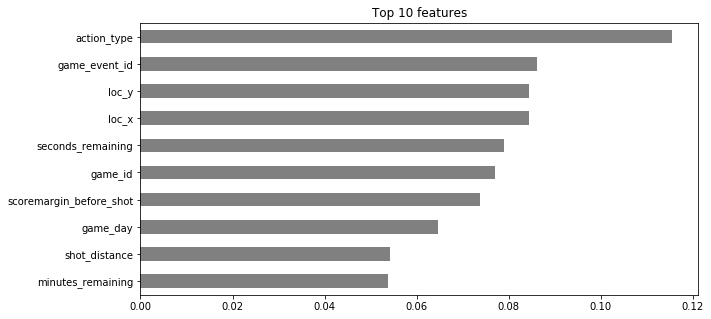

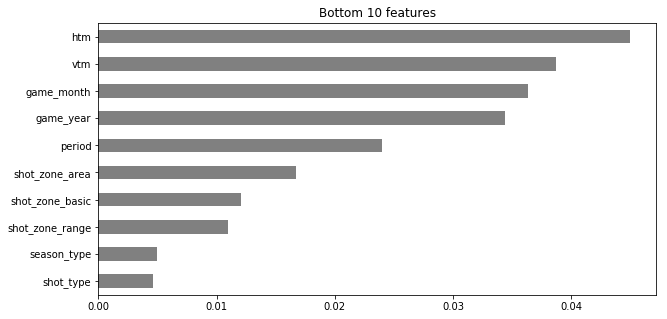

In [121]:
# get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 10
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

n = 10
plt.figure(figsize = (10, n/2))
plt.title(f'Bottom {n} features')
importances.sort_values()[:n].plot.barh(color='grey');

### Confusion Matrix
<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [160]:
total = 85 + 58 + 8 + 36
print('Accuracy:',(36+85)/total)
precision = 36/(36+58)
print('Precision:', precision)
recall = 36/(36+8)
print('Recall:', recall)
print('F1:', 2*(recall * precision) / (recall + precision))

Accuracy: 0.6470588235294118
Precision: 0.3829787234042553
Recall: 0.8181818181818182
F1: 0.5217391304347826


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

In [0]:
y_pred = pipeline.predict(X_test)

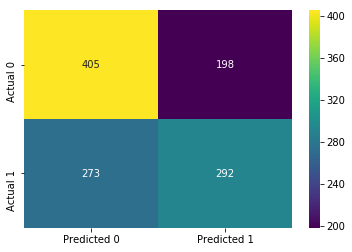

In [175]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}'  for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);

In [176]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       603
           1       0.60      0.52      0.55       565

    accuracy                           0.60      1168
   macro avg       0.60      0.59      0.59      1168
weighted avg       0.60      0.60      0.59      1168



In [178]:
from sklearn.linear_model import LogisticRegression

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(ce.OneHotEncoder()
                        , LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500))

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5336454066705676
